In [2]:
import cv2
import time
import imutils 
from collections import deque

import tensorflow as tf
import os
import shutil
import numpy as np
import random
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from pathlib import Path
import re
import cv2
from keras import backend as K
tf.__version__
import glob
import imageio

import skimage.feature
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

#check if tensorflow gpu is being used
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("tensorflow version:", tf.__version__)

Num GPUs Available:  1
tensorflow version: 2.10.0


In [3]:
def detect_bbox(img,bbox_image):
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        
        # Debugging statements
        # if area > 1:
        #     print("Area of contour is: {}".format(area))
        
        areaMin = 100
        areaMax = 600
        if area > areaMin and area < areaMax:
            # print(area)
            cv2.drawContours(bbox_image, cnt, -1, (255, 0, 255), 7)
            peri = cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
            # print(len(approx))
            x, y, w, h = cv2.boundingRect(approx)
            cv2.rectangle(bbox_image, (x, y), (x + w, y + h), (0, 255, 0), 5)


In [4]:
def drow_the_lines(img, lines):
    img = np.copy(img)
    blank_image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(blank_image, (x1,y1), (x2,y2), (0, 255, 0), thickness=10)

    img = cv2.addWeighted(img, 0.8, blank_image, 1, 0.0)
    return img

V3.1 - Threshold Masking

In [7]:
#videos to choose from
NeedleViz_path1 = 'Data/edited data/102622_Water.mp4'
NeedleViz_path2 = 'Data/edited data/102822_Water.mp4'
NeedleViz_oilAndLatex = 'Data/edited data/oil and latex/capture_5_2022-11-12T16-56-03.mp4'
NeedleViz_gelAndLatex = 'Data/edited data/ultrasound gel and latex/capture_4_2022-11-12T17-33-19.mp4'
NeedleViz_clarius1 = 'Data/edited data/clarius_FinalPrototype_needlejustWater.mp4'
NeedleViz_clarius2 = 'Data/edited data/clarius_FinalPrototype_needlejustWater2.mp4'
NeedleViz_clarius3 = 'Data/edited data/clarius_FinalPrototype_needleWithSolid.mp4'
NeedleViz_clarius4 = 'Data/edited data/clarius_FinalPrototype_needleWithSolid2.mp4'
NeedleViz_clarius5 = 'Data/edited data/clarius_FinalPrototype_needleWithSolid3.mp4'



#control playback speed
frame_rate = 30

# vc = cv2.VideoCapture(0) #opens camera
vc = cv2.VideoCapture(NeedleViz_clarius5)

fgbg = cv2.createBackgroundSubtractorMOG2(history=100, varThreshold=10) #pretty good: (100,200)

frameWidth = 440
frameHeight = 440
vc.set(3, frameWidth)
vc.set(4, frameHeight)

size = (frameWidth, frameHeight)

#Preparing to create output videos
image_lst = []

if (vc.isOpened()== False): 
  print("Error opening video  file")

while(vc.isOpened()):
    rval, frame = vc.read()
    
    if rval == True:

        #Initial Frame preprocessing
        ##############################################################
        resized_frame = cv2.resize(frame, (frameWidth,frameHeight))
        resized_frame = cv2.cvtColor(resized_frame, cv2.COLOR_RGB2GRAY)
        ##############################################################


        #Achieving desired region of interest within Raw Frame
        ##############################################################
        row_start = 140 #previously 94
        row_end = 348
        col_start = 195 #previously 166
        col_end = 235 #previously 275

        ROI_frame = resized_frame[row_start:row_end, col_start:col_end] #old one was [94:348, 166:275]
        ROI_image = np.zeros_like(resized_frame)
        x = row_start 
        y = col_start 
        for i in range(0, row_end-row_start):
            for j in range(0, col_end-col_start):
                if ROI_frame[i][j] != 0:
                    ROI_image[x + i, y + j] = ROI_frame[i, j]
        ############################################################## 
      
        #Applying Initial Filters
        #############################################################
        
        ### THRESHOLDING ###
        thresh = cv2.threshold(ROI_image, 90, 255, cv2.THRESH_BINARY)[1]

        ### MORPHOLOGICAL OPERATIONS ###
        dilate = cv2.dilate(thresh, None, iterations=1)
        erode = cv2.erode(dilate, None, iterations=1)
        dilate_2 = cv2.dilate(erode, None, iterations=1)
        
        #############################################################
        
        #Applying Edge and Bounding box detection
        #############################################################
        canny = cv2.Canny(dilate_2, 73,200)
        bbox = resized_frame.copy()
        detect_bbox(canny,bbox)
        
        #############################################################


        #Line Detection
        #############################################################
        # houghline = blank_img.copy()

        # lines = cv2.HoughLinesP(canny,
        #                 rho=6,
        #                 theta=np.pi/180,
        #                 threshold=160,
        #                 lines=np.array([]),
        #                 minLineLength=40,
        #                 maxLineGap=25)
        
        # print(lines)

        # image_with_lines = drow_the_lines(houghline, lines)   
        ##############################################################

        
        #Overlaying segmentations onto B-mode image
        #############################################################################################
        # fgmaskV2_color = cv2.applyColorMap(bbox, cv2.COLORMAP_INFERNO)
        # resized_frame_revert = cv2.cvtColor(resized_frame, cv2.COLOR_GRAY2RGB)
        # overlay = cv2.addWeighted(resized_frame_revert, 0.5, fgmaskV2_color, 0.5, 1.0)
        # cv2.imshow("Bmode Overlay", overlay)
        ###########################################################################################

        # Debugging Statements
        cv2.imshow('normal frame', resized_frame)
        cv2.imshow('ROI frame', ROI_image)
        cv2.imshow('thresholding', thresh)
        cv2.imshow('Morphological Operations', dilate_2)
        cv2.imshow('Canny Edge Detection', canny)
        cv2.imshow('Object Detection', bbox)
        
        #Saving comparison frames as gif 
        # resized_frame = cv2.cvtColor(resized_frame, cv2.COLOR_GRAY2BGR)
        # overlay = cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR)
        # stack = np.hstack((resized_frame, overlay))
        # cv2.imshow("stacked", stack)
        # image_lst.append(stack)

        # Press Q on keyboard to  exit
        if cv2.waitKey(frame_rate) & 0xFF == ord('q'): #original waitkey is 25
            break
    
    #Break out of loop if video is done
    else:
        break  

vc.release() #Release the video capture object

# Close window
cv2.destroyAllWindows()

In [6]:
#Saving Video as GIF
# imageio.mimsave('Outputs/roughV3_video.gif', image_lst, fps=30)

Single Frame Feature Extraction

In [79]:
frameList = []

vc = cv2.VideoCapture(NeedleViz_clarius5)

if (vc.isOpened()== False): 
  print("Error opening video  file")

while(vc.isOpened()):
    rval, frame = vc.read()
    
    if rval == True:
      frameList.append(frame)
        
    #Break out of loop if video is done
    else:
        break  

vc.release() #Release the video capture object

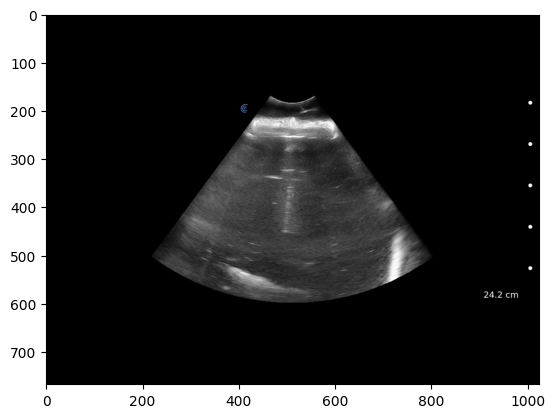

In [80]:
image = frameList[30]
image_refined = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.imshow(image)

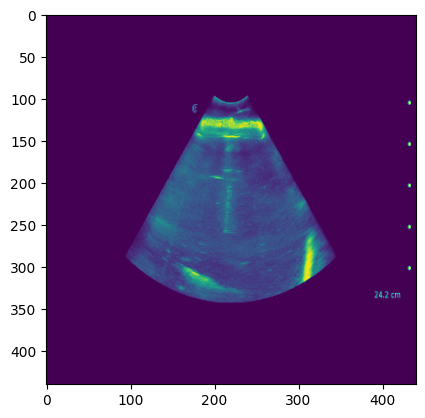

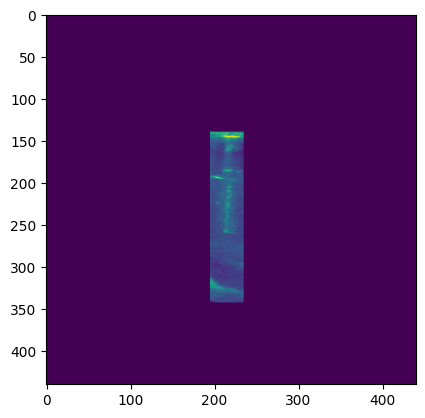

In [81]:
### ROI FRAME EXTRACTION ###

size = (440, 440)

#Initial Frame preprocessing
resized_frame = cv2.resize(image, size)
resized_frame = cv2.cvtColor(resized_frame, cv2.COLOR_RGB2GRAY)

plt.figure()
plt.imshow(resized_frame)

#Achieving desired region of interest within Raw Frame
row_start = 140 #previously 94
row_end = 348
col_start = 195 #previously 166
col_end = 235 #previously 275

ROI_frame = resized_frame[row_start:row_end, col_start:col_end] #old one was [94:348, 166:275]
ROI_image = np.zeros_like(resized_frame)
x = row_start 
y = col_start 
for i in range(0, row_end-row_start):
    for j in range(0, col_end-col_start):
        if ROI_frame[i][j] != 0:
            ROI_image[x + i, y + j] = ROI_frame[i, j]

plt.figure()
plt.imshow(ROI_image)

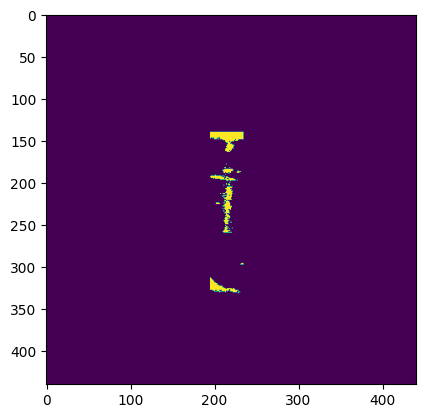

In [82]:
### BLURRING AND THRESHOLDING ###

thresh = cv2.threshold(ROI_image, 90, 255, cv2.THRESH_BINARY)[1]
plt.figure()
plt.imshow(thresh)

# adapt_thresh = cv2.adaptiveThreshold(thresh, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, 10)

# plt.figure()
# plt.imshow(adapt_thresh)

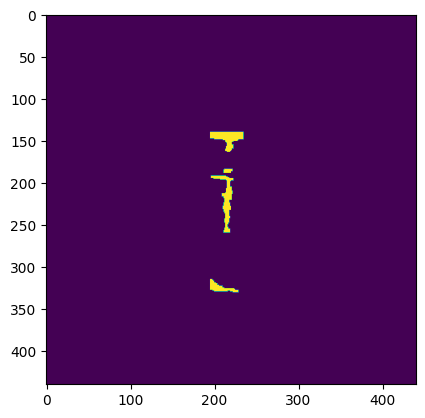

In [83]:
### MORPHOLOGICAL OPERATIONS ###
dilate = cv2.dilate(thresh, None, iterations=1)
erode = cv2.erode(dilate, None, iterations=2)
dilate_2 = cv2.dilate(erode, None, iterations=1)

plt.figure()
plt.imshow(dilate_2)

# kernelSizes = [(3, 3), (5, 5), (7, 7)]
# # loop over the kernels sizes
# for kernelSize in kernelSizes:
# 	# construct a rectangular kernel from the current size and then
# 	# apply an "opening" operation
#     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize)
# 	opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)


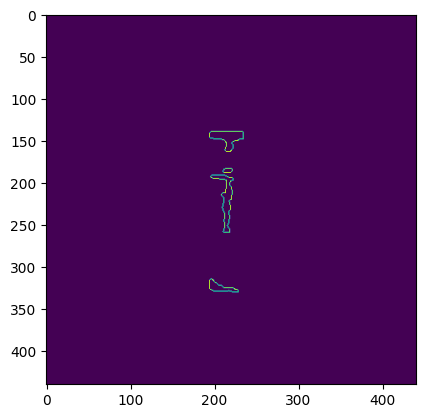

In [84]:
### CANNY EDGE DETECTION ###
canny = cv2.Canny(dilate_2, 73,200)

plt.imshow(canny)

Area of contour is: 222.5
222.5
Area of contour is: 534.0
534.0
Area of contour is: 48.0
Area of contour is: 494.5
494.5


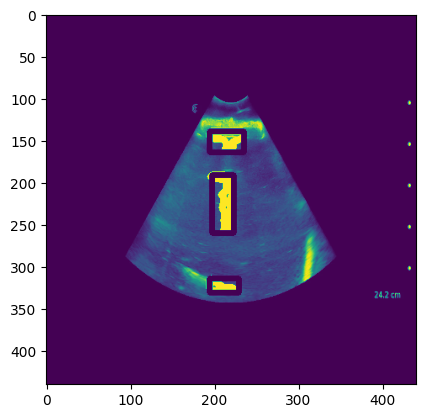

In [92]:
bbox = resized_frame.copy()
detect_bbox(canny,bbox)
plt.imshow(bbox)